In [15]:
import json
import re
import time
import random
from datetime import datetime
import numpy as np
from PIL import Image,ImageOps
import os
from IPython.display import display, clear_output
from IPython.display import Image as _Imgdis
from pprint import pprint
from sklearn.utils import shuffle
import h5py
import matplotlib.pyplot as plt

In [25]:
def get_score(value):
    distribution = np.logspace(-1,1,num=10,base=2.5)
    idx = (np.abs(distribution - value)).argmin()
    return idx+1

In [26]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [27]:
def timestamp_to_date(timestmap):
    return datetime.utcfromtimestamp(timestmap).strftime("%Y-%m-%d %H:%M:%S")

In [142]:
def get_photos_info(profile, bins = 10):    
    current_time = time.time()
    photos_in_averaging = 10
    with open('../scrap_data/{}/{}.json'.format(profile,profile)) as f:
        d = json.load(f)
    images = d['GraphImages']
    pattern = "[0-9_]*_n.jpg"
    images_info = dict(photos=[])
    for image in images:
        if len(re.findall(pattern,image['urls'][0]))==0:
            continue
        images_info['photos'].append(dict(file = re.search(pattern,image['urls'][0]).group(),
                                         likes = image['edge_media_preview_like']['count'],
                                         timestamp = image['taken_at_timestamp'],
                                         date = timestamp_to_date(image['taken_at_timestamp'])))

    images_info = sorted(images_info['photos'],key=lambda k: k['timestamp'])
    
    expected_score = [None]*photos_in_averaging \
                     +list(running_mean([im['likes'] for im in images_info[:-1]],photos_in_averaging))
    
    for idx,image in enumerate(images_info):
        image.update({"expected":"{}".format(expected_score[idx])})


    result = list(filter(lambda im:im['expected']!='None' and current_time-im['timestamp']>3600*24,images_info))

    
    
    for image in result:
        ratio = image['likes']/float(image['expected'])
        image.update({"ratio":"{}".format(ratio)})
        image.update({"score":get_score(ratio)})
        
    expected_scores_sorted = sorted([im['ratio'] for im in result])
    
    for image in result:
        image.update({"relative_score":int((expected_scores_sorted.index(image['ratio']))/(len(result)/bins))+1})
    return result

In [187]:
#profile = "shainblumphotography"
profile ="bejamin"
pattern = "[0-9_]*_n.jpg"
result = get_photos_info(profile)

Working with 243 images
Image example: 


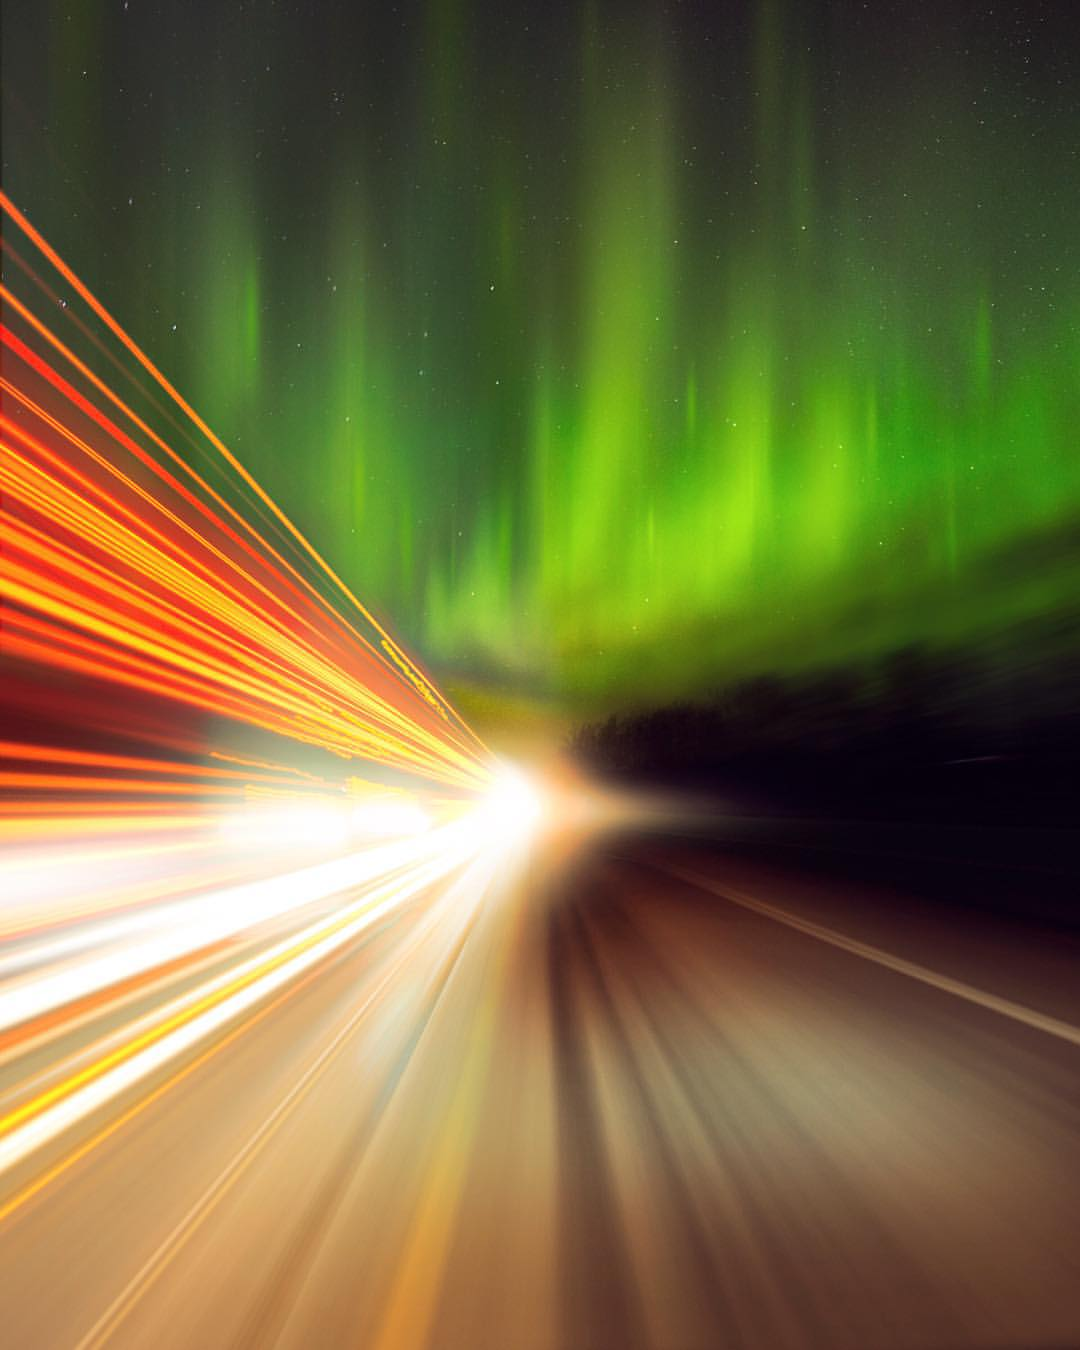

{'date': '2015-10-28 00:27:21',
 'expected': '6066.7',
 'file': '10005741_921135344590756_264541478_n.jpg',
 'likes': 4785,
 'ratio': '0.7887319300443404',
 'relative_score': 2,
 'score': 4,
 'timestamp': 1445992041}


In [261]:
folder = "../scrap_data/"+profile

#onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.endswith(".jpg")]
onlyfiles = [im['file'] for im in result]

#file = onlyfiles[-3]
file = onlyfiles[random.randrange(len(onlyfiles))]
print("Working with {0} images".format(len(onlyfiles)))
print("Image example: ")


display(_Imgdis(filename=folder + "/" + file , width=240, height=320))
pprint(list(filter(lambda im:im['file']==file, result))[0])

In [265]:
def get_data(profile):
    result = get_photos_info(profile)
    onlyfiles = [im['file'] for im in result]
    folder = "../scrap_data/"+profile
    dataset = np.ndarray(dtype='int8',shape=(len(onlyfiles),224,224,3))
    labels = np.ndarray(shape=(len(onlyfiles),2))
    wrong_indices = []
    for idx,im in enumerate(result):
        if idx%50 == 0:
            print("Progress: {}%".format(idx/len(onlyfiles)))
        try:
            original_image = Image.open(folder+"/"+im['file'])
            dataset[idx] = np.array(ImageOps.fit(original_image, (224, 224), Image.ANTIALIAS))
            labels[idx] = [im['ratio'],im['relative_score']]
        except OSError as e:
            wrong_indices.append(idx)
            print("Error at Index:{}".format(idx))
    return np.delete(dataset,wrong_indices,0),np.delete(labels,wrong_indices,0)

In [266]:
dataset,labels = get_data('africatracks')

Progress: 0.0%
Progress: 0.13368983957219252%
Progress: 0.26737967914438504%
Progress: 0.40106951871657753%
Progress: 0.5347593582887701%
Progress: 0.6684491978609626%
Progress: 0.8021390374331551%
Progress: 0.9358288770053476%


In [9]:
#%time dataset,labels = get_data(profile)

In [10]:
# print(dataset.shape)
# print(labels.shape)

In [15]:
# dataset_size_in_MB = dataset.nbytes/1000000
# dataset_size_in_MB

In [16]:
# photo_idx = random.randrange(len(labels))
# worst_photo_index = (np.squeeze(np.where(labels == min(labels))))
# best_photo_index = (np.squeeze(np.where(labels == max(labels))))

# Image.fromarray(dataset[photo_idx].astype('uint8'))

# print("Random photo score: {}".format(labels[photo_idx]))

# print("Worst photo score: {}".format(labels[worst_photo_index]))
# Image.fromarray(dataset[worst_photo_index].astype('uint8'))

# print("Best photo score: {}".format(labels[best_photo_index]))
# Image.fromarray(dataset[best_photo_index].astype('uint8'))

In [285]:
path_to_scrap_data = "../scrap_data/"
path_to_input_data = "../input_data/"
pattern = "[0-9_]*_n.jpg"
photos_counter = 0
photographers_list = [f for f in os.listdir(path_to_scrap_data) if not os.path.isfile(os.path.join(path_to_scrap_data, f))]
already_processed = [f[:-5] for f in os.listdir(path_to_input_data) if f.endswith(".hdf5")]
photographers_list = list(set(photographers_list) - set(already_processed) - set(['storyofsage']))
for photographer in photographers_list:
    print("Current photographer: {}...".format(photographer))
    result = get_photos_info(photographer)
    dataset,labels = get_data(photographer)
    dataset,labels = shuffle(dataset,labels,random_state = 1)
    with h5py.File("{}{}.hdf5".format(path_to_input_data,photographer), "w") as f:
        f.create_dataset("data", data = dataset)
        f.create_dataset("labels", data = labels[:,0])
        f.create_dataset("scores", data = labels[:,1])
    photos_counter+=dataset.shape[0]
    clear_output()
    print("Done with photographer: {}. \nTotal # of saved photos: {}\n".format(photographer,photos_counter))
    del dataset
    del labels

Done with photographer: kateholsteinphoto. 
Total # of saved photos: 30717

